In [1]:
!nvidia-smi

Mon May 20 16:44:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:51:00.0 Off |                  Off |
| 30%   25C    P8              19W / 300W |     83MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

In [5]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from keras.optimizers import Adagrad

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [6]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.jpg')))
        
    def readImages(self,):
        self.returListImages()

        self.finalImages = []
        self.finalImageSegmentation= []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = str(img)
                imgSeg = img.replace('.jpg', "_mask.png")

                img = cv2.resize(cv2.imread(img,cv2.IMREAD_GRAYSCALE ), (64,64))
                img  = img/255
                
                imgSeg = (cv2.resize(cv2.imread(str(imgSeg), cv2.IMREAD_GRAYSCALE), (64,64)))
                imgSeg = np.array(imgSeg)
                if np.max(imgSeg):
                    imgSeg = imgSeg / np.max(imgSeg)
                self.finalImageSegmentation.append(imgSeg)
                
                self.finalImages.append(img)
                labels.append(label)


        imagesSegmentation = np.array(self.finalImageSegmentation)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        
        return images, imagesSegmentation,labels

In [7]:
readDatasetObject = ReadDataset('tumor_dataset/',
                               ['healthy','glioma','meningioma','pituitary'],
                               (128, 128, 3))
images, imagesSegmentation , labels = readDatasetObject.readImages()

In [8]:
np.max(imagesSegmentation[3000])

1.0

In [9]:
images.shape,imagesSegmentation.shape, labels[0]

((5490, 64, 64), (5490, 64, 64), 0)

Sample images included in the dataset for each class

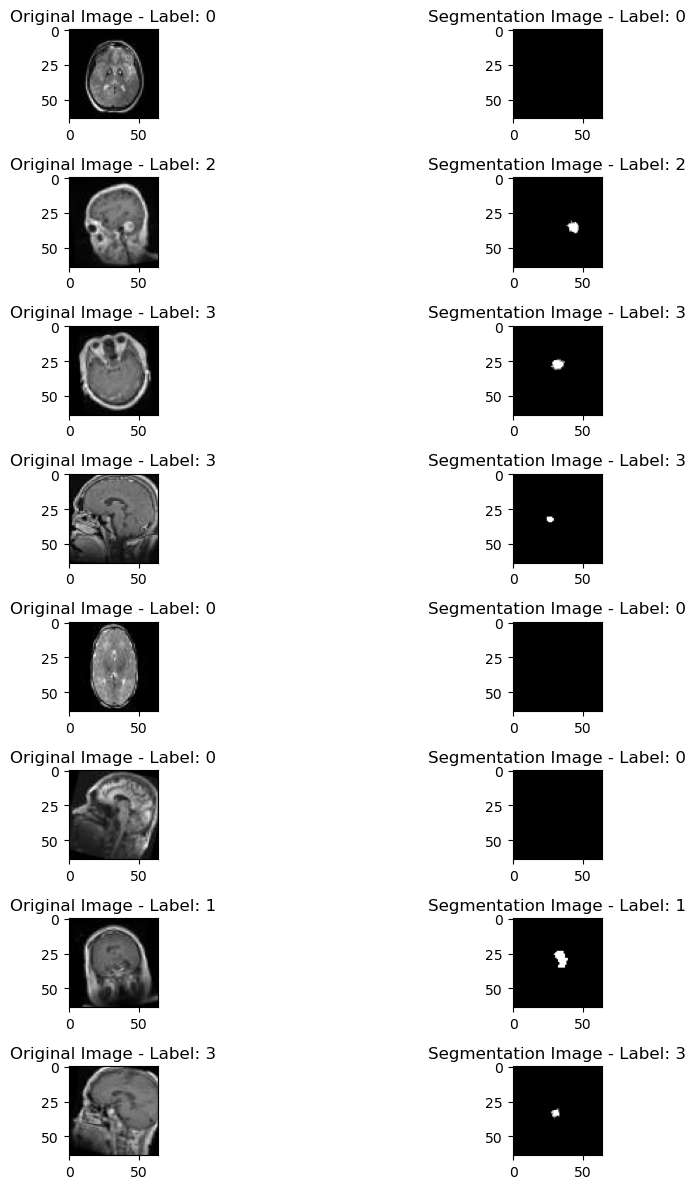

In [10]:
plt.figure(figsize=(12, 12))

# Generate random indices for selecting images
indices = np.random.randint(0, len(labels), size=(8,))

for i in range(8):
    plt.subplot(8, 2, 2*i + 1)
    plt.imshow(images[indices[i]], cmap='gray')
    plt.title('Original Image - Label: {}'.format(labels[indices[i]]))

    plt.subplot(8, 2, 2*i + 2)
    plt.imshow(imagesSegmentation[indices[i]], cmap='gray')
    plt.title('Segmentation Image - Label: {}'.format(labels[indices[i]]))

plt.tight_layout()
plt.show()

In [11]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
        self.threshold = 0.9
        
    def data(self, images, imagesSegmentation,  labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.imagesSegmentation = imagesSegmentation
        self.labels = ytrain
        
        
    def samples(self, G, noise, labels):
        generated_images, segmentation_images = G.predict([noise, labels])
        ys = np.argmax(labels, axis=1)

        plt.figure(figsize=(18, 6))

        for i in range(16):
            plt.subplot(4, 8, 2 * i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.title('Generated - Label: {}'.format(ys[i]))

            plt.subplot(4, 8, 2 * i + 2)
            plt.imshow(segmentation_images[i], cmap='gray')
            plt.title('Segmentation - Label: {}'.format(ys[i]))

        plt.tight_layout()
        plt.show()
        
    def custom_round(self, x):
        # Custom rounding function with a specified threshold
        @tf.custom_gradient
        def _custom_round(x):
            # Forward pass
            result = tf.where(x >= self.threshold, 1.0, 0.0)

            # Define the gradient
            def grad(dy):
                return dy  # Identity gradient for custom rounding

            return result, grad

        return _custom_round(x)
    
    

    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(1, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)

        #for segmentation output
        # Contracting Path
        conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
        conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        # Bottleneck
        conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

        # Expanding Path
        up5 = UpSampling2D(size=(2, 2))(conv4)
        up5 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up5)
        merge5 = concatenate([conv3, up5], axis=3)
        conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
        conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

        up6 = UpSampling2D(size=(2, 2))(conv5)
        up6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
        merge6 = concatenate([conv2, up6], axis=3)
        conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
        conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

        up7 = UpSampling2D(size=(2, 2))(conv6)
        up7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
        merge7 = concatenate([conv1, up7], axis=3)
        conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
        conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

        # Output Layer
        segmentation_output = Conv2D(1, 1, activation='sigmoid')(conv7)

        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = [x, segmentation_output],
                                           name = 'generator')           
    def discriminator(self, imgInput, imgSegInput):
        imgInput = tf.expand_dims(imgInput, axis=-1)
        imgSegInput = tf.expand_dims(imgSegInput, axis=-1)
        x = tf.concat([imgInput, imgSegInput], axis=-1)

        
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(2, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(4,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = [imgInput, imgSegInput],
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorImgInput = layers.Input(shape = (64,64))
        discriminatorImgSegInput = layers.Input(shape = (64,64))

        labelsInput = layers.Input(shape = (4, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorImgInput, discriminatorImgSegInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'categorical_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'categorical_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
    
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realImgSeg = self.imagesSegmentation[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(4), size = (self.batch_size)),
                                                      num_classes = 4)
            fake_images_and_segmentations = G.predict([noize, fakeLabels], verbose=0)

            # Modify the code based on your desired output
            fakeImages = tf.squeeze(fake_images_and_segmentations[0])  # Extracting the images from the output
            fakeSegmentations = tf.squeeze(fake_images_and_segmentations[1])            
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            
            allImages = np.vstack([realImages, fakeImages])
            allSegmentations = np.vstack([realImgSeg, fakeSegmentations])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            
            _, dlossTag, dlossLabels = D.train_on_batch([allImages, allSegmentations], [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [12]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 1000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64,1), kernel_size = 5)

In [13]:
acgan.data(images, imagesSegmentation, labels)

In [14]:
G, D, GAN = acgan.build()

2024-05-04 11:07:26.667564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-04 11:07:26.672004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-04 11:07:26.672163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-04 11:07:26.672379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.concat (TFOpLambda)         (None, 64, 64, 2)    0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 32)   1632        ['tf.concat[1][0]']  

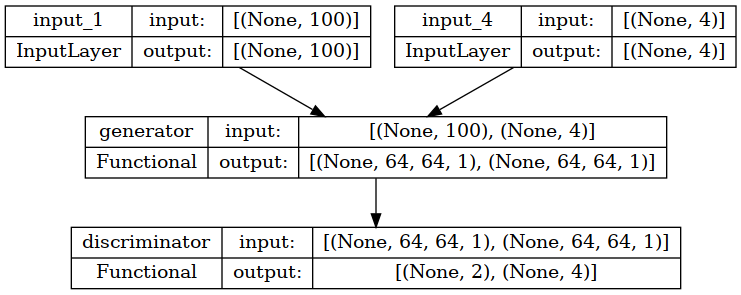

In [15]:
tf.keras.utils.plot_model(GAN, show_shapes = True)

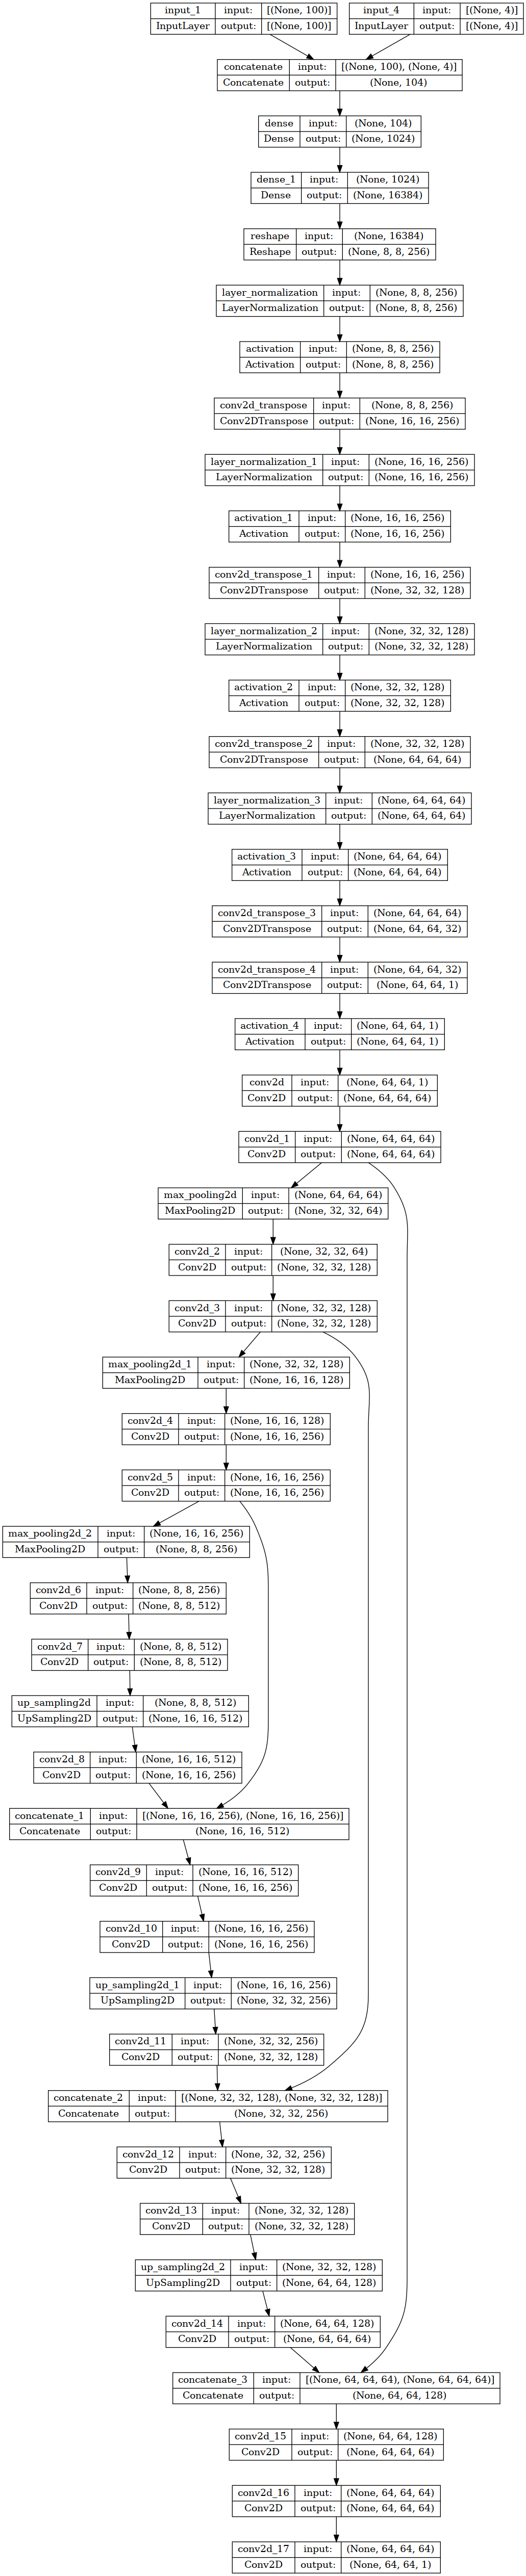

In [16]:
tf.keras.utils.plot_model(G, show_shapes = True)

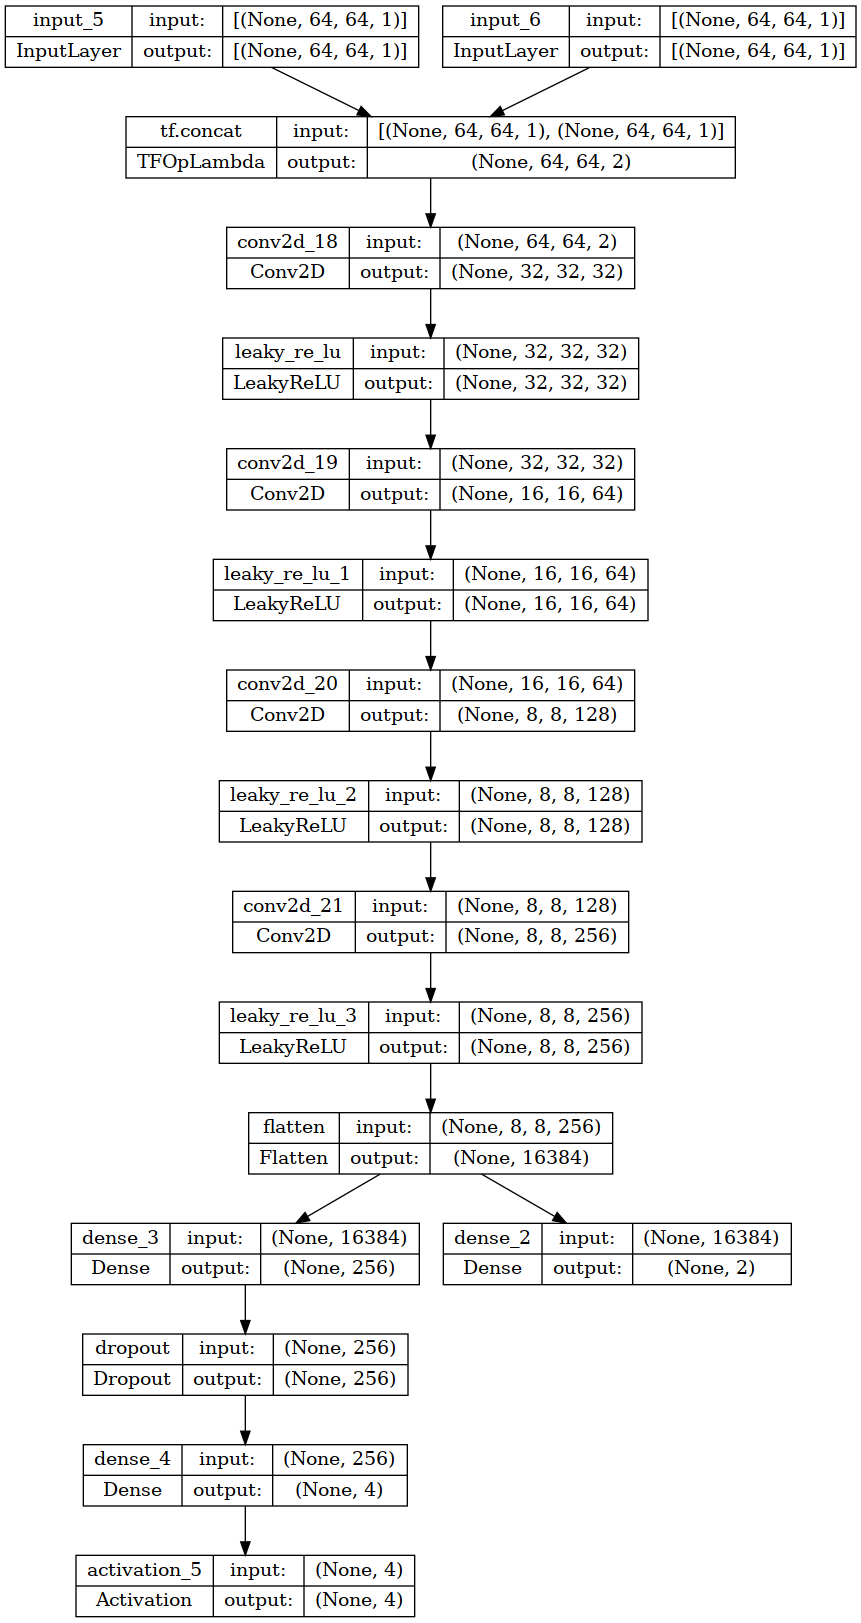

In [17]:
tf.keras.utils.plot_model(D, show_shapes = True)

In [ ]:
acgan.trainAlgorithm(G, D, GAN)

2024-05-04 11:07:28.438276: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-04 11:07:28.530370: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def save_images(G, images, batch_size=500):
    # Create directories for each tumor class if they don't exist
    tumor_classes = 4
    output_dir = './output'
    real_images_dir = os.path.join(output_dir, 'real_images')
    generated_images_dir = os.path.join(output_dir, 'generated_images')
    
    for i in range(tumor_classes):
        os.makedirs(os.path.join(real_images_dir, f'class_{i}'), exist_ok=True)
        os.makedirs(os.path.join(generated_images_dir, f'class_{i}'), exist_ok=True)

    # Randomly select images for each class
    for tumor_class in range(tumor_classes):
        # Select images for the current class
        class_indices = [i for i, label in enumerate(labels) if label == tumor_class]
        selected_indices = random.sample(class_indices, batch_size)
        
        # Select real images from the class
        selected_real_images = [images[i] for i in selected_indices]
        
        # Saving real images
        for j, real_image in enumerate(selected_real_images):
            real_image_path = os.path.join(real_images_dir, f'class_{tumor_class}', f'real_image_{j}.png')
            plt.imsave(real_image_path, real_image, cmap='gray')
        
        # Generating and saving fake images for the current class
        for j in range(batch_size):
            noise = tf.random.uniform(shape=(1, 100), minval=-1, maxval=1)
            fake_label = tf.keras.utils.to_categorical(tumor_class, num_classes=tumor_classes).reshape(1, tumor_classes)
            generated_images, _ = G.predict([noise, fake_label])
            
            generated_image_path = os.path.join(generated_images_dir, f'class_{tumor_class}', f'generated_image_{j}.png')
            generated_image_array = np.expand_dims(generated_images[0], axis=2)
            
            plt.imsave(generated_image_path, generated_image_array, cmap='gray')
    
    print(f"{batch_size} real and generated images for each of the 4 classes saved successfully.")

# Assuming you have the generator model (G) and dataset loaded as images and labels
# Uncomment and adjust the function call as needed
# save_images(G, images, batch_size=500)


In [ ]:
import os
import random
save_images(G, images,batch_size=32)


In [ ]:
!python -m pytorch_fid ./output/generated_images ./output/real_images

In [ ]:
G.save('/kaggle/working/generator.h5')

In [ ]:
G = tf.keras.models.load_model('/kaggle/working/generator.h5')

- We have to make sure that the images that the generator generates are correct, and that they actually include pathological conditions, and this is done by generating a large number of samples, using a neural network to classify the images, and then using the trained neural network, in order to classify the basic images that are included in the basic dataset.

In [ ]:
datasetGenerationSize = 30
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [ ]:
noize.shape, newlabels.shape

In [ ]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

In [ ]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

- Samples generated by the generator for each case (healthy person, person with pneumonia).

In [ ]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In order to be able to evaluate the images generated by the generating neural network, we can do so by proposing a neural structure dedicated to classifying the images generated by the generating neural network, and then we return to the basic images included in the dataset, and we evaluate the performance of the classified neural network that It was trained on the generated images, in order to see if the learned characteristics of the generated images can give high results on the basic images included in the dataset.

In [11]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         

                                                                 

 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         

                                                                 

 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 16, 16, 1

In [12]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60

375/375 [==============================] - 45s 89ms/step - loss: 0.2485 - val_loss: 0.5733

Epoch 2/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0989 - val_loss: 0.1620

Epoch 3/60

375/375 [==============================] - 32s 85ms/step - loss: 0.0754 - val_loss: 0.0421

Epoch 4/60

375/375 [==============================] - 32s 85ms/step - loss: 0.0620 - val_loss: 0.0384

Epoch 5/60

375/375 [==============================] - 31s 84ms/step - loss: 0.0553 - val_loss: 0.0338

Epoch 6/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0515 - val_loss: 0.0298

Epoch 7/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0463 - val_loss: 0.0274

Epoch 8/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0438 - val_loss: 0.0255

Epoch 9/60

375/375 [==============================] - 32s 84ms/step - loss: 0.0401 - val_loss: 0.0236

Epoch 10/60

375/375 [==============================] - 31s 83ms

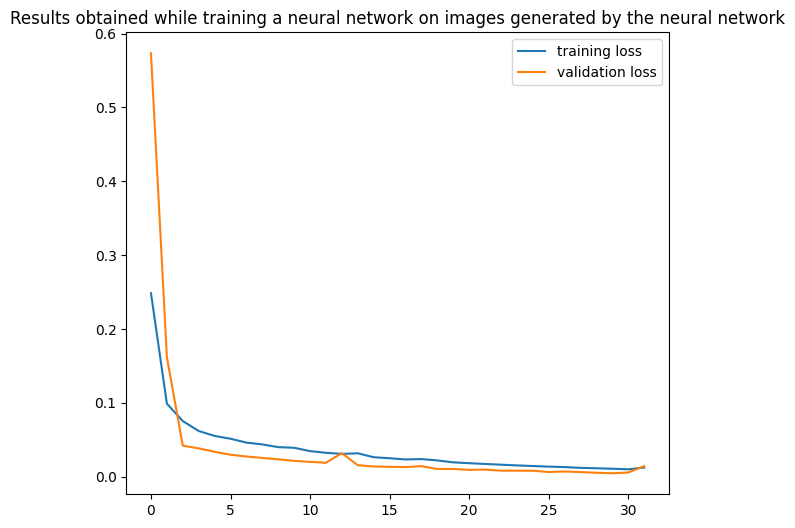

In [27]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

- Now, after training on the images generated by the generator, we will test the neural network on the basic images included in the dataset.

- We will use several measures in the evaluation to study what is the ability of the generative adversarial network to capture the basic features that characterize each class, and whether the second classified network extracted the features included in the generated images.
- Are the attributes that were extracted from the images generated by the generator, can be used on the original images included in the dataset.
- This helps in the ability to study what was actually generated, and whether the focus was really on the cases that the X-ray images made him have pneumonia or not.

In [14]:
m.evaluate(images, labels)

163/163 [==============================] - 3s 15ms/step - loss: 0.2774


0.27743175625801086

In [15]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 2s 14ms/step


TensorShape([5216])

In [16]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

In [19]:
accuracy_score(y_pred, labels)*100

93.90337423312883

In [20]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support



           0       0.98      0.82      0.89      1595

           1       0.93      0.99      0.96      3621



    accuracy                           0.94      5216

   macro avg       0.95      0.91      0.92      5216

weighted avg       0.94      0.94      0.94      5216




In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1309,  286],
       [  32, 3589]])

In [22]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,1309,286
PNEUMONIA,32,3589


In [25]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 95.75773745997866, recall_score: 99.11626622479977, precision_score: 92.61935483870968


<Axes: >

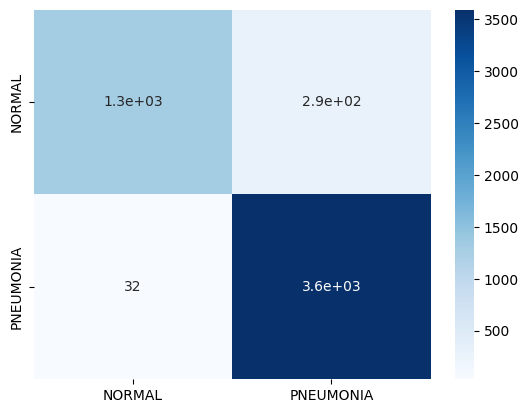

In [26]:
sns.heatmap(cmObject, annot = True, cmap="Blues")